In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import math

from scipy.optimize import minimize

import sys
sys.path.insert(0, '../scripts/')
import utils as utl
from decision_tree import Decision_Tree_Classifier

In [2]:
class Decision_Tree_Regressor(Decision_Tree_Classifier):
    def __init__(self, min_n_data = None) -> None:
        super().__init__()
        if min_n_data is None:
            self.min_n_data = 50
        else:
            self.min_n_data = min_n_data

    def fit(self, 
            X, y):
        df_split = X.copy()
        df_split['res'] = y.copy()
        df_split['pred'] = y.copy()
        df_split = df_split.reset_index(drop = True)

        self.res_dict = self.des_tree_nodes(df_split)

    def des_tree_nodes(self, df: pd.DataFrame) -> Dict:
        dct_res = {}    
        attr_max_gain, x_v = self.get_min_mse(df)

        dct_res['type'] = 'cont'
        dct_res['attr'] = attr_max_gain
        splits = [x_v]
        dct_res['vals'] = splits

        childs = {}
        df_s = df.sort_values(attr_max_gain)
        df_low = df_s.loc[df_s[attr_max_gain] <= x_v]
        df_high = df_s.loc[df_s[attr_max_gain] > x_v]

        if len(df_low) > self.min_n_data:
            childs['0'] = self.des_tree_nodes(df_low)
        else:
            childs['0'] = df_low['res'].mean()

        if len(df_high) > self.min_n_data:
            childs['1'] = self.des_tree_nodes(df_high)
        else:
            childs['1'] = df_high['res'].mean()

        dct_res['res'] = childs
        return dct_res

    def mse(self, y: pd.Series, y_pred: pd.Series) -> float:
        y_np = y.to_numpy()
        yp_np = y_pred.to_numpy()
        return np.mean((y_np - yp_np)**2)
    
    def get_split_pred(self, df_s: pd.DataFrame, c: str, i: int) -> Tuple[pd.Series, float]:
        """Splits the dataframe at the given index. Returns the predicted value as the mean of the target before and after the split.

        Parameters
        ----------
        df_s : pd.DataFrame
            Input and target data sorted by column c
        c : str
            column that serves as x values
        i : int
            Index for splitting

        Returns
        -------
        Tuple[pd.Series, float]
            pd.Series: Predicted value with the means before and after the split
            float: column value at which the split was performed (average of df_s[c].iloc[i] and df_s[c].iloc[i+1])
        """
        x_split = np.mean([df_s[c].iloc[i-1:i+1]])
        yA_m = df_s['res'].loc[df_s[c] <= x_split].mean()
        yB_m = df_s['res'].loc[df_s[c] > x_split].mean()

        df_s['pred'].loc[df_s[c] <= x_split] = yA_m
        df_s['pred'].loc[df_s[c] > x_split] = yB_m    
        return df_s['pred'], x_split

    def get_min_mse_column(self, df: pd.DataFrame, c: str) -> List:
        """Sorts the dataframe by column c, and returns the index and value of the split necessary to minimize the mean squared error

        Parameters
        ----------
        df : pd.DataFrame
            Input and target data.
        c : str
            Column for which the splits will be performed

        Returns
        -------
        List
            _description_
        """
        mse_res = []
        x_s = []
        df_s = df.sort_values(c)
        for i in range(1,len(df_s)):
            df_s['pred'], x_split = self.get_split_pred(df_s, c, i)
            x_s.append(x_split)
            mse_res.append(self.mse(df_s['res'], df_s['pred']))

        return [x_s[np.argmin(mse_res)],np.min(mse_res)]

    def get_min_mse(self, df: pd.DataFrame) -> Tuple[str,float]:
        """Obtains the column and the split value of the column which allows to minimize the mse

        Parameters
        ----------
        df : pd.DataFrame
            Input and target dat

        Returns
        -------
        Tuple[str,float]
            str: Column that minimizes the mse
            float: Value of df[c] at which the mse is minimized
        """
        cols = [x for x in df.columns if x not in ['res','pred']]
        x_vals = []

        for c in cols:
            x_vals.append(self.get_min_mse_column(df, c))

        xv_np = np.array(x_vals)
        min_index = np.argmin(xv_np[:,1])
        attr = cols[min_index]
        x_v = x_vals[min_index][0]

        return attr, x_v    

C:\Users\an2fe\AppData\Local\Temp\ipykernel_24456\1287543436.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = utl.min_max_scaling(X[c])[0]


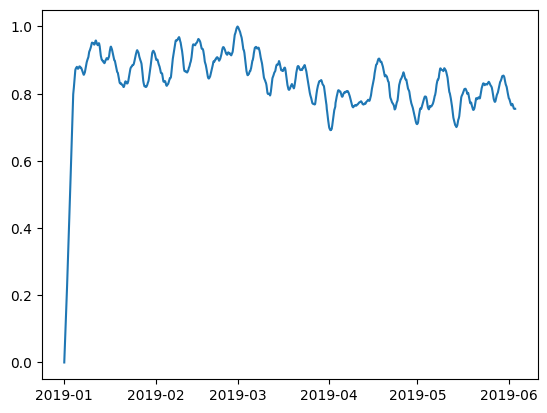

In [3]:
n = 10
roll_time = '3d'


df_orig = pd.read_csv('../data/1.raw/electricityConsumptionAndProductioction.csv', parse_dates=['DateTime'],index_col=['DateTime'])
df = df_orig.iloc[:len(df_orig)//n]
X_cols = ['Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']
y_col = 'Production'

df = df.rolling(roll_time).sum()

X = df[X_cols]
for c in X.columns:
    X[c] = utl.min_max_scaling(X[c])[0]

y = df[y_col]
y = utl.min_max_scaling(y)[0]

plt.plot(y)

In [4]:
dtr = Decision_Tree_Regressor()
dtr.fit(X,y)

In [5]:
y_p = dtr.predict(X)
utl.r_squared(y.to_numpy(), y_p.to_numpy())

0.9815310099047435

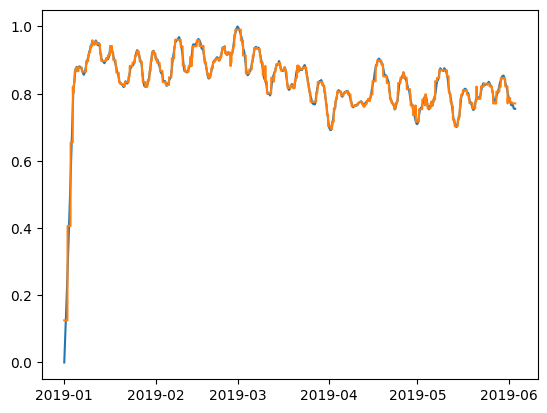

In [6]:
plt.plot(y)
plt.plot(y_p)
plt.show()